# SmartExplain AI – Interpretable & Adaptive House Price Prediction Engine

## 1️⃣ Title & Abstract

**SmartExplain AI** is a production-level ML system combining gradient-descent linear regression with explainability and what-if simulation for house price prediction.

**Abstract:** We implement linear regression from scratch using batch, mini-batch, and SGD with L2 regularization. The system provides transparent predictions via per-feature contributions and supports what-if analysis.

## 2️⃣ Problem Statement

Predict median house values in California using census data. We require:
- Interpretable predictions (feature contributions)
- Flexible optimization (batch/minibatch/SGD, momentum, LR decay)
- Reproducible pipeline

## 3️⃣ Mathematical Formulation

**Linear model:**
$$y = Xw + b$$

**Cost Function (L2 regularized):**
$$J(w,b) = \frac{1}{2m} \sum_{i=1}^{m} (y_{pred}^{(i)} - y^{(i)})^2 + \lambda \sum_{j} w_j^2$$

**Gradient Updates:**
$$\frac{\partial J}{\partial w} = \frac{1}{m} X^T (y_{pred} - y) + 2\lambda w$$
$$\frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i} (y_{pred}^{(i)} - y^{(i)})$$

In [1]:
import sys
sys.path.insert(0, '..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
RANDOM_STATE = 42

## 4️⃣ Data Loading & EDA

In [2]:
df = pd.read_csv('../data/housing.csv')
print(df.shape)
df.head()

(20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [4]:
df['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

## 5️⃣ Feature Engineering

In [5]:
from core.feature_engineering import FeatureEngineer

fe = FeatureEngineer(random_state=RANDOM_STATE, use_log_transform=True, cap_outliers=True)
X, y = fe.fit_transform(df, target_col='median_house_value')
feature_names = fe.get_feature_names()
print('Features:', feature_names)
print('X shape:', X.shape)

Features: ['longitude', 'latitude', 'median_income', 'total_rooms', 'total_bedrooms', 'housing_median_age', 'population', 'households', 'area_location_rating', 'age_depreciation', 'distance_from_center', 'rooms_per_household', 'bedrooms_per_room', 'income_area', 'income_age', 'dist_location', 'log_rooms', 'log_bedrooms', 'log_population', 'log_households', 'log_income', 'ocean_<1H OCEAN', 'ocean_INLAND', 'ocean_ISLAND', 'ocean_NEAR BAY', 'ocean_NEAR OCEAN', 'longitude_sq', 'latitude_sq', 'median_income_sq', 'total_rooms_sq', 'total_bedrooms_sq', 'housing_median_age_sq', 'population_sq', 'households_sq', 'area_location_rating_sq', 'age_depreciation_sq', 'longitude_x_latitude', 'longitude_x_median_income', 'longitude_x_total_rooms', 'longitude_x_total_bedrooms', 'longitude_x_housing_median_age', 'longitude_x_population', 'longitude_x_households', 'longitude_x_area_location_rating', 'longitude_x_age_depreciation', 'latitude_x_median_income', 'latitude_x_total_rooms', 'latitude_x_total_bed

## 6️⃣ Model Implementation

Weights shape: (81,)
Bias: -8032.910578168507


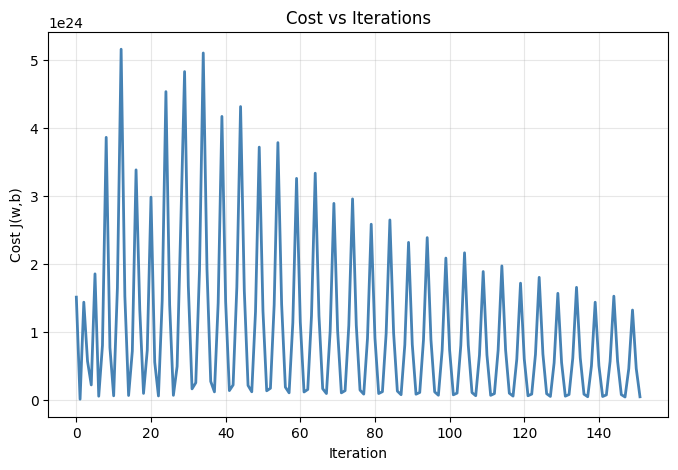

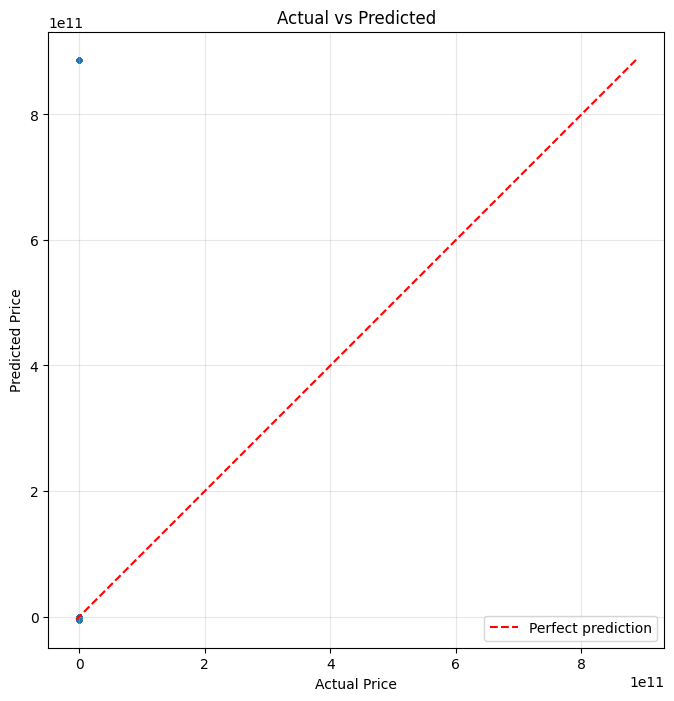

In [6]:
from core.model import LinearRegressionGD

model = LinearRegressionGD(
    learning_rate=0.05,
    n_iterations=3000,
    regularization=0.008,
    mode='batch',
    use_momentum=True,
    momentum=0.9,
    use_lr_decay=True,
    decay_type='time',
    early_stopping=True,
    patience=150,
    random_state=RANDOM_STATE
)
model.fit(X, y, feature_names=feature_names)
y_pred = model.predict(X)
print('Weights shape:', model.weights.shape)
print('Bias:', model.bias)

from visualization.plots import plot_cost_vs_iterations, plot_actual_vs_predicted
plot_cost_vs_iterations(model.cost_history)
plt.show()
plot_actual_vs_predicted(y[:2000], y_pred[:2000])
plt.show()

## 7️⃣ Optimization Variants

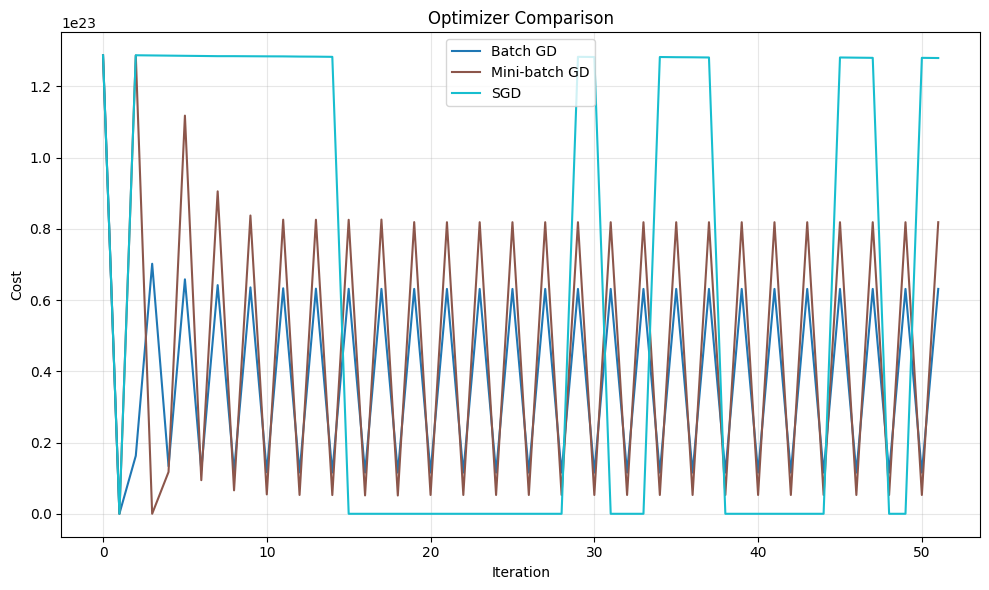

In [7]:
from visualization.plots import plot_optimizer_comparison

histories = {}
for mode, name in [('batch','Batch GD'), ('minibatch','Mini-batch GD'), ('sgd','SGD')]:
    m = LinearRegressionGD(learning_rate=0.01, n_iterations=200, batch_size=64 if mode=='minibatch' else None,
                          mode=mode, random_state=RANDOM_STATE)
    m.fit(X[:5000], y[:5000], feature_names=feature_names)
    histories[name] = m.cost_history

plot_optimizer_comparison(histories)
plt.tight_layout()
plt.show()

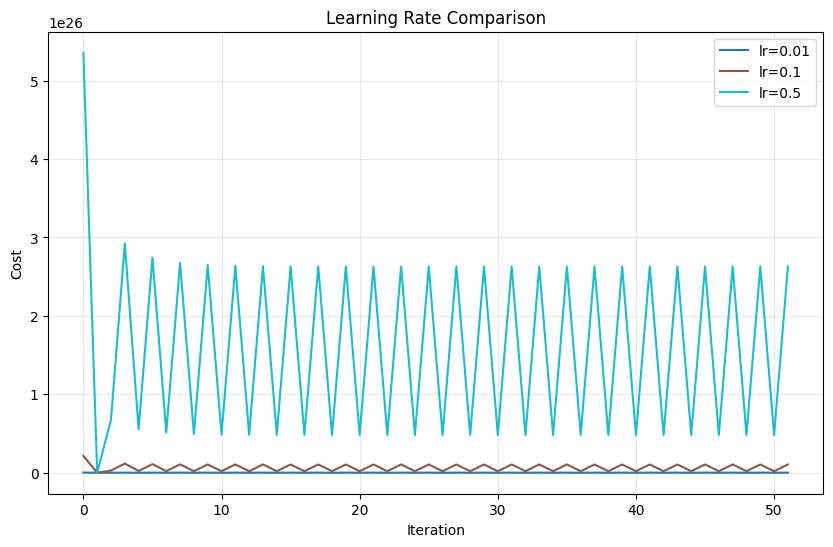

In [8]:
lr_histories = {}
for lr, name in [(0.01,'lr=0.01'), (0.1,'lr=0.1'), (0.5,'lr=0.5')]:
    m = LinearRegressionGD(learning_rate=lr, n_iterations=200, random_state=RANDOM_STATE)
    m.fit(X[:3000], y[:3000], feature_names=feature_names)
    lr_histories[name] = m.cost_history

from visualization.plots import plot_learning_rate_comparison
plot_learning_rate_comparison(lr_histories)
plt.show()

## 8️⃣ Explainability

In [9]:
from core.explainability import FeatureExplainer

explainer = FeatureExplainer(model.weights, model.bias, feature_names)
result = explainer.explain(X[:1], index=0)
print('Total predicted price:', result['total_prediction'][0])
print('Contributions:', list(zip(result['feature_names'], result['contributions'][0].round(2))))

Total predicted price: 887101422946.9868
Contributions: [('longitude', np.float64(0.0)), ('latitude', np.float64(0.0)), ('median_income', np.float64(0.0)), ('total_rooms', np.float64(-0.0)), ('total_bedrooms', np.float64(-0.0)), ('housing_median_age', np.float64(-0.0)), ('population', np.float64(-0.0)), ('households', np.float64(-0.0)), ('area_location_rating', np.float64(-0.0)), ('age_depreciation', np.float64(-0.0)), ('distance_from_center', np.float64(0.0)), ('rooms_per_household', np.float64(0.0)), ('bedrooms_per_room', np.float64(0.0)), ('income_area', np.float64(-0.0)), ('income_age', np.float64(0.0)), ('dist_location', np.float64(0.0)), ('log_rooms', np.float64(-0.0)), ('log_bedrooms', np.float64(-0.0)), ('log_population', np.float64(0.0)), ('log_households', np.float64(-0.0)), ('log_income', np.float64(0.0)), ('ocean_<1H OCEAN', np.float64(0.0)), ('ocean_INLAND', np.float64(0.0)), ('ocean_ISLAND', np.float64(0.0)), ('ocean_NEAR BAY', np.float64(887101430979.86)), ('ocean_NEAR O

## 9️⃣ 3D Cost Surface Visualization

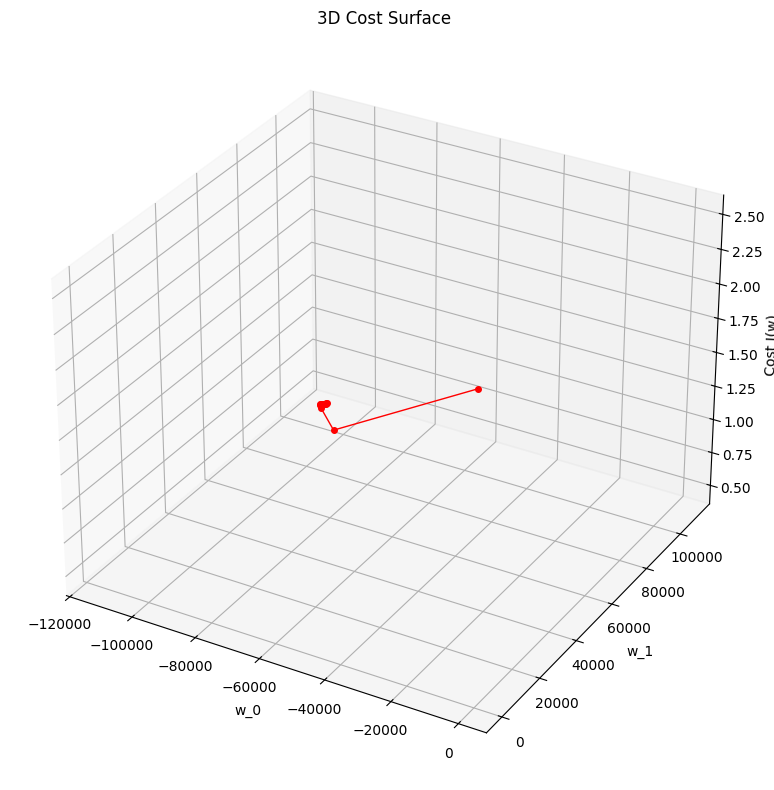

In [10]:
from visualization.cost_surface import plot_cost_surface_3d, get_gradient_descent_path

Xs, ys = X[:1000], y[:1000]
path = get_gradient_descent_path(Xs, ys, 0, 1, n_steps=15, lr=0.5)
fig = plot_cost_surface_3d(Xs, ys, weight_idx1=0, weight_idx2=1, path=path)
plt.tight_layout()
plt.show()

## 🔟 Evaluation Metrics

In [11]:
from core.metrics import mae, mse, rmse, r2_score

print('MAE:', mae(y, y_pred))
print('MSE:', mse(y, y_pred))
print('RMSE:', rmse(y, y_pred))
print('R2:', r2_score(y, y_pred))

MAE: 99065591860.5231
MSE: 8.731482713592428e+22
RMSE: 295490824114.59796
R2: -6557381056543.378


## 1️⃣1️⃣ Comparison With Sklearn

In [12]:
from sklearn.linear_model import LinearRegression as SklearnLR

sk_model = SklearnLR()
sk_model.fit(X, y)
sk_pred = sk_model.predict(X)

print('Sklearn R2:', r2_score(y, sk_pred))
print('Our GD R2:', r2_score(y, y_pred))

Sklearn R2: 0.7333310999993132
Our GD R2: -6557381056543.378


## 1️⃣2️⃣ Conclusion & Future Work

We built SmartExplain AI with gradient-descent linear regression, feature engineering, explainability, and optimization variants. Future work: neural networks, tree-based models, uncertainty quantification.